In [1]:
import anndata
import scanpy as sc
import pandas as pd
from scipy import sparse
from modules.process_data import *
from collections import Counter
from matplotlib.ticker import PercentFormatter
from modules.utils import *
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from scipy import stats
from statsmodels.stats.multitest import multipletests
import re
from scipy.stats import ttest_ind
from statsmodels.stats.multitest import fdrcorrection
from tqdm import tqdm

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2024-06-06 19:17:53.801694: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-06 19:17:54.354309: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


In [2]:
mapping = {'Multiplet': 'Multiplet',
           'SampleTag17_flex': 'WT-DMSO',
           'SampleTag18_flex': '3xTg-DMSO',
           'SampleTag19_flex': 'WT-SCDi',
           'SampleTag20_flex': '3xTg-SCDi',
           'Undetermined': 'Undetermined'}

In [3]:
#load sc data
adata = anndata.read_h5ad("data/fede_count.h5ad")

In [4]:
#data cleaning
adata = rm_high_mt(adata, threshold=0.6)
adata = filter_cells_by_gene_counts(adata)

In [5]:
adata = rm_low_exp(adata, threshold=0.01)
#sc.pp.normalize_total(adata, target_sum=1, exclude_highly_expressed=True, max_fraction=0.2)

In [6]:
sample_tags = pd.DataFrame(adata.obs.Sample_Tag)
sample_tags.index = sample_tags.index.astype('int64')
sample_tags = pd.DataFrame(sample_tags['Sample_Tag'].map(mapping))
sc_df = pd.DataFrame(adata.X.toarray() if hasattr(adata.X, 'toarray') else adata.X, index=adata.obs_names, columns=adata.var_names)
sc_df.index = sc_df.index.astype('int64')
sc_df = sc_df.join(sample_tags)

In [7]:
#remove cell with sample tags "multiplet" or "undetermined"
sc_df = sc_df[~sc_df['Sample_Tag'].isin(['Multiplet', 'Undetermined'])]

In [8]:
adata1_df = sc_df[sc_df['Sample_Tag'] == 'WT-DMSO'].drop(['Sample_Tag'], axis=1)

In [9]:
adata2_df = sc_df[sc_df['Sample_Tag'] == '3xTg-DMSO'].drop(['Sample_Tag'], axis=1)

In [34]:
import scanpy as sc
import pandas as pd
import numpy as np
from tqdm import tqdm

# Ensure that the indices are strings
adata1_df.index = adata1_df.index.astype(str)
adata2_df.index = adata2_df.index.astype(str)
adata1_df.columns = adata1_df.columns.astype(str)
adata2_df.columns = adata2_df.columns.astype(str)

# Combine the data into a single DataFrame and ensure data is float
count_data = pd.concat([adata1_df, adata2_df], axis=0).astype(float)
sample_info = pd.DataFrame({
    'condition': ['WT'] * adata1_df.shape[0] + ['TG'] * adata2_df.shape[0]
}, index=count_data.index)

# Ensure sample_info index is string
sample_info.index = sample_info.index.astype(str)

# Create an AnnData object
adata = sc.AnnData(count_data.values, obs=sample_info)

# Set the variable names (gene names)
adata.var_names = count_data.columns.astype(str)

# Set the observation names (sample names)
adata.obs_names = count_data.index.astype(str)

# Normalize and log-transform the data
#sc.pp.normalize_total(adata, target_sum=1e4)
#sc.pp.log1p(adata)

# Initialize lists to store the gene names, fold changes, and p-values
gene_names = []
fold_changes = []
p_values = []
log10_pvals = []

# Perform differential expression analysis gene by gene
for gene in tqdm(adata.var_names):
    # Subset AnnData for the specific gene
    adata_subset = adata[:, [gene]]

    # Perform Wilcoxon rank-sum test
    sc.tl.rank_genes_groups(adata_subset, groupby='condition', method='wilcoxon', use_raw=False, key_added=f'rank_{gene}')

    # Extract the results
    results = adata_subset.uns[f'rank_{gene}']

    # Get p-value and log fold change
    p_value = results['pvals'][0][0]
    fold_change = results['logfoldchanges'][0][0]

    # Ensure p-value is within a reasonable range
    log10_pval = -np.log10(max(p_value, 1e-300))

    # Store the results
    gene_names.append(gene)
    fold_changes.append(fold_change)
    p_values.append(p_value)
    log10_pvals.append(log10_pval)

# Create a DataFrame with the results
results_df = pd.DataFrame({
    'Gene': gene_names,
    'log2_fold_change': fold_changes,
    'p-value': p_values,
    'log10_p-value': log10_pvals
})

# Print the results
print(deg_results_df.head())


  0%|                                                 | 0/26294 [00:00<?, ?it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  0%|                                       | 25/26294 [00:00<03:39, 119.62it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  0%|                                       | 38/26294 [00:00<03:38, 120.36it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  0%|                                       | 51/26294 [00:00<03:36, 121.30it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  0%|                                       | 64/26294 [00:00<03:34, 122.19it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  0%|                                       | 77/26294 [00:00<03:31, 124.02it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


  0%|▏                                      | 90/26294 [00:00<03:33, 122.96it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  0%|▏                                     | 103/26294 [00:00<03:35, 121.50it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  0%|▏                                     | 116/26294 [00:00<03:33, 122.47it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  0%|▏                                     | 129/26294 [00:01<03:32, 123.38it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  1%|▏                                     | 142/26294 [00:01<03:30, 124.00it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  1%|▏                                     | 155/26294 [00:01<03:32, 123.16it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  1%|▏                                     | 168/26294 [00:01<03:33, 122.61it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


  1%|▎                                     | 181/26294 [00:01<03:30, 123.81it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  1%|▎                                     | 194/26294 [00:01<03:31, 123.66it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  1%|▎                                     | 207/26294 [00:01<03:31, 123.52it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  1%|▎                                     | 220/26294 [00:01<03:32, 122.90it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  1%|▎                                     | 233/26294 [00:01<03:33, 121.94it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  1%|▎                                     | 246/26294 [00:02<03:33, 121.73it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  1%|▎                                     | 259/26294 [00:02<03:34, 121.30it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  1%|▍                                     | 272/26294 [00:02<03:34, 121.20it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  1%|▍                                     | 285/26294 [00:02<03:34, 121.36it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.ob

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c


/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  1%|▍                                     | 298/26294 [00:02<03:34, 121.44it/s]

/home/client/projects/sc_alz/sc_env/lib/python3.10/site-packages/anndata/_core/anndata.py:1209: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  df[key] = c
  1%|▍                                     | 298/26294 [00:02<03:33, 121.81it/s]


KeyboardInterrupt: 

In [32]:
results

{'params': {'groupby': 'condition',
  'reference': 'rest',
  'method': 'wilcoxon',
  'use_raw': False,
  'layer': None,
  'corr_method': 'benjamini-hochberg'},
 'names': rec.array([('mt-Nd6', 'mt-Nd6')],
           dtype=[('TG', 'O'), ('WT', 'O')]),
 'scores': rec.array([(0.36218876, -0.36218876)],
           dtype=[('TG', '<f4'), ('WT', '<f4')]),
 'pvals': rec.array([(0.71721098, 0.71721098)],
           dtype=[('TG', '<f8'), ('WT', '<f8')]),
 'pvals_adj': rec.array([(0.71721098, 0.71721098)],
           dtype=[('TG', '<f8'), ('WT', '<f8')]),
 'logfoldchanges': rec.array([(0.07696495, -0.07696495)],
           dtype=[('TG', '<f4'), ('WT', '<f4')])}

In [16]:
# Assuming result_df is a pandas DataFrame with the necessary data
fold_change = results_df['log2_fold_change']
p_value = results_df['p-value']

In [17]:
# Define significant genes
significant = p_value < 0.05
non_significant = ~significant
significant_outside_range = significant & ((fold_change > 1) | (fold_change < -1))
significant_inside_range = significant & ((fold_change >= -1) & (fold_change <= 1))

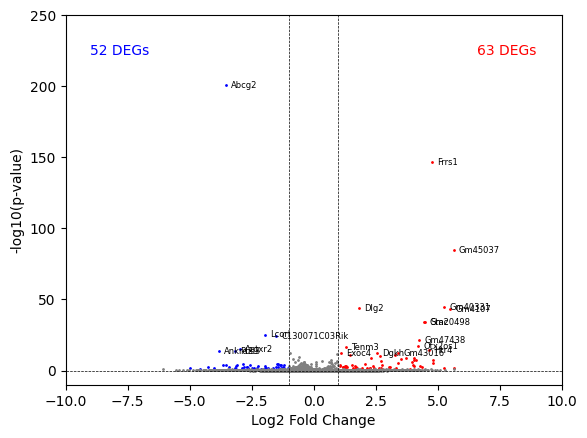

In [18]:
# Get the top 20 significant genes outside the range -1 to 1 for cleaner annotation
top_genes = results_df[significant_outside_range & finite_log10_pvalue].nlargest(20, 'log10_p-value')

# Create the volcano plot
plt.scatter(fold_change[significant_outside_range & (fold_change > 0)], log10_pvalue[significant_outside_range & (fold_change > 0)], s=1, c='red')
plt.scatter(fold_change[significant_outside_range & (fold_change <= 0)], log10_pvalue[significant_outside_range & (fold_change <= 0)], s=1, c='blue')
plt.scatter(fold_change[non_significant | significant_inside_range], log10_pvalue[non_significant | significant_inside_range], s=1, c='grey')

# Add dotted lines
plt.axvline(x=-1, color='black', linestyle='--', linewidth=0.5)
plt.axvline(x=1, color='black', linestyle='--', linewidth=0.5)
plt.axhline(y=0, color='black', linestyle='--', linewidth=0.5)

# Annotate the top genes
for _, row in top_genes.iterrows():
    plt.annotate(row['Gene'], (row['log2_fold_change'] + 0.2, -np.log10(row['p-value'])), ha='left', va='center', fontsize=6)

# Count and annotate DEGs
positive_deg_num = (significant_outside_range & (fold_change > 0)).sum()
negative_deg_num = (significant_outside_range & (fold_change <= 0)).sum()

plt.annotate(f'{positive_deg_num} DEGs', xy=(9, 230), ha='right', va='top', fontsize=10, color='red')
plt.annotate(f'{negative_deg_num} DEGs', xy=(-9, 230), ha='left', va='top', fontsize=10, color='blue')

plt.xlabel('Log2 Fold Change')
plt.ylabel('-log10(p-value)')
plt.xlim(-10, 10)
plt.ylim(-10, 250)

plt.savefig('volcano_plot.png')
plt.show()

In [ ]:
positive_deg = results_df[(results_df["p-value"] < 0.05) & (results_df["log2_fold_change"] > 1)]['Gene'].tolist()
positive_deg = [x.upper() for x in positive_deg]

negative_deg = results_df[(results_df["p-value"] < 0.05) & (results_df["log2_fold_change"] <= -1)]['Gene'].tolist()
negative_deg = [x.upper() for x in negative_deg]

In [ ]:
with open('positive_deg', 'w') as file:
    for gene in positive_deg:
        file.write(gene + '\n')

with open('negative_deg', 'w') as file:
    for gene in negative_deg:
        file.write(gene + '\n')

In [ ]:
tsv_file_path = 'positive_go.txt'
df = pd.read_csv(tsv_file_path, delimiter='\t', skiprows=11)

In [ ]:
df['upload_1 (fold Enrichment)'] = pd.to_numeric(df['upload_1 (fold Enrichment)'], errors='coerce')
df['upload_1 (FDR)'] = pd.to_numeric(df['upload_1 (FDR)'], errors='coerce')

df = df.dropna(subset=['upload_1 (fold Enrichment)', 'upload_1 (FDR)'])

df = df[df['upload_1 (fold Enrichment)'] >= 1]

df['-log10(FDR)'] = -np.log10(df['upload_1 (FDR)'])

top_processes = df.nlargest(20, '-log10(FDR)')

top_processes['GO biological process complete'] = top_processes['GO biological process complete'].apply(lambda x: re.sub(r'\s*\([^)]*\)', '', x))

top_processes = top_processes.sort_values(by='-log10(FDR)', ascending=False)

plt.figure(figsize=(10, 8))
norm = plt.Normalize(top_processes['-log10(FDR)'].min(), top_processes['-log10(FDR)'].max())
colors = plt.cm.viridis(norm(top_processes['-log10(FDR)']))
bars = plt.barh(top_processes['GO biological process complete'], top_processes['upload_1 (fold Enrichment)'], color=colors)

plt.xlabel('Fold Enrichment')
plt.ylabel('UP-Biological Process')
plt.gca().invert_yaxis()  # To display the highest -log10(FDR) at the top

sm = plt.cm.ScalarMappable(cmap='viridis', norm=norm)
sm.set_array([])
cbar = plt.colorbar(sm, ax=plt.gca())
cbar.ax.set_title('-log10(FDR)', pad=20)

plt.tight_layout()
plt.savefig('up_bio_process.png')
plt.show()


In [ ]:
positive_deg = significant & (fold_change >= 1)
negative_deg = significant & (fold_change <= -1)

positive_deg = results_df[positive_deg].nlargest(100, 'log10_p-value')['Gene'].tolist()
negative_deg = results_df[negative_deg].nlargest(100, 'log10_p-value')['Gene'].tolist()

In [ ]:
adata1 = anndata.AnnData(X=adata1_df.values, obs=pd.DataFrame(index=adata1_df.index), var=pd.DataFrame(index=adata1_df.columns))

In [ ]:
adata2 = anndata.AnnData(X=adata2_df.values, obs=pd.DataFrame(index=adata2_df.index), var=pd.DataFrame(index=adata2_df.columns))

In [ ]:
import anndata
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt

adata1_subset = adata1[:, positive_deg].copy()
adata2_subset = adata2[:, positive_deg].copy()
adata1_subset.obs['batch'], adata2_subset.obs['batch'] = 'WT-DMSO', '3xTg-DMSO'

combined_adata = anndata.concat([adata1_subset, adata2_subset])
sc.pp.scale(combined_adata, max_value=10)

mean_expr = combined_adata.to_df().groupby(combined_adata.obs['batch']).mean().T

sns.set(context='notebook', font_scale=1.2)
cg = sns.clustermap(mean_expr, cmap='coolwarm', linewidths=.5, figsize=(10, 8), row_cluster=True, col_cluster=False)

cg.ax_heatmap.set_yticklabels([])
cg.cax.set_position([0.9, .2, .03, .45]) 
cg.ax_heatmap.xaxis.set_label_position('top')
cg.ax_heatmap.xaxis.tick_top()
cg.ax_heatmap.set_xlabel('')
for tick in cg.ax_heatmap.get_xticklabels():
    tick.set_color('black')
    tick.set_ha('center')
    tick.set_rotation(0)
# Adjust layout and save the figure with the colorbar included
plt.savefig('positive_heatmap.png', bbox_inches='tight')
plt.show()


In [ ]:
adata1_subset = adata1[:, negative_deg].copy()
adata2_subset = adata2[:, negative_deg].copy()
adata1_subset.obs['batch'], adata2_subset.obs['batch'] = 'WT-DMSO', '3xTg-DMSO'

combined_adata = anndata.concat([adata1_subset, adata2_subset])
sc.pp.scale(combined_adata, max_value=10)

mean_expr = combined_adata.to_df().groupby(combined_adata.obs['batch']).mean().T

sns.set(context='notebook', font_scale=1.2)
cg = sns.clustermap(mean_expr, cmap='coolwarm', linewidths=.5, figsize=(10, 8), row_cluster=True, col_cluster=False)

cg.ax_heatmap.set_yticklabels([])
cg.cax.set_position([0.9, .2, .03, .45]) 
cg.ax_heatmap.xaxis.set_label_position('top')
cg.ax_heatmap.xaxis.tick_top()
cg.ax_heatmap.set_xlabel('')
for tick in cg.ax_heatmap.get_xticklabels():
    tick.set_color('black')
    tick.set_ha('center')
    tick.set_rotation(0)
plt.savefig('negative_heatmap.png', bbox_inches='tight')
plt.show()